### importer les bibliothe 

In [1]:
from pyspark.sql import SparkSession
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from pyspark.sql.types import IntegerType, DoubleType, StringType
from pyspark.sql.functions import col, avg, count, max, min , sum
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.utils import to_categorical

### Afficher le dataframe

In [2]:
#creer un session de spark
spark = SparkSession.builder.appName("Planéte").getOrCreate()

In [3]:
# Lecture du fichier CSV depuis HDFS
df_planets = spark.read.option("header", True).csv("hdfs://namenode:9000/user/hive/planets/planets_dataset.csv")

In [4]:
df_planets.show(5)

+------------+---------+--------+------------------+------------------+------------------+-----------------+--------------+-----------+
|        Name|Num_Moons|Minerals|           Gravity|    Sunlight_Hours|       Temperature|    Rotation_Time|Water_Presence|Colonisable|
+------------+---------+--------+------------------+------------------+------------------+-----------------+--------------+-----------+
|Planet_18329|        5|      59| 1.981602859469247|5.8168191458771705|28.381006239674264|56.76091939405808|             0|          0|
|Planet_28900|        8|     672|1.3881504830806715|14.715293728903166| 27.48564614824687| 51.0340563211323|             0|          0|
|Planet_56161|        3|     764|2.5308267251520093|22.902523479273974| 63.39082702246432|42.99324764351807|             1|          0|
|Planet_24869|        4|     881| 0.272197404132533|1.1764842767184982| 36.99844187739444|29.49224607367769|             1|          0|
|Planet_70594|        7|    1003|1.7310599130799

In [5]:
# Renommer les colonnes en français
df_planets = df_planets.withColumnRenamed("Name", "Nom") \
               .withColumnRenamed("Num_Moons", "Nombre_de_Lunes") \
               .withColumnRenamed("Minerals", "Mineraux") \
               .withColumnRenamed("Gravity", "Gravite") \
               .withColumnRenamed("Sunlight_Hours", "Heures_d_Ensoleillement") \
               .withColumnRenamed("Temperature", "Temperature") \
               .withColumnRenamed("Rotation_Time", "Temps_de_Rotation") \
               .withColumnRenamed("Water_Presence", "Presence_d_Eau") \
               .withColumnRenamed("Colonisable", "Colonisable")

# Affichage du DataFrame avec les noms de colonnes en français
df_planets.show(5)


+------------+---------------+--------+------------------+-----------------------+------------------+-----------------+--------------+-----------+
|         Nom|Nombre_de_Lunes|Mineraux|           Gravite|Heures_d_Ensoleillement|       Temperature|Temps_de_Rotation|Presence_d_Eau|Colonisable|
+------------+---------------+--------+------------------+-----------------------+------------------+-----------------+--------------+-----------+
|Planet_18329|              5|      59| 1.981602859469247|     5.8168191458771705|28.381006239674264|56.76091939405808|             0|          0|
|Planet_28900|              8|     672|1.3881504830806715|     14.715293728903166| 27.48564614824687| 51.0340563211323|             0|          0|
|Planet_56161|              3|     764|2.5308267251520093|     22.902523479273974| 63.39082702246432|42.99324764351807|             1|          0|
|Planet_24869|              4|     881| 0.272197404132533|     1.1764842767184982| 36.99844187739444|29.49224607367769

### Analyser le dataframe

In [6]:
# Vérifier les types après la conversion
df_planets.printSchema()

root
 |-- Nom: string (nullable = true)
 |-- Nombre_de_Lunes: string (nullable = true)
 |-- Mineraux: string (nullable = true)
 |-- Gravite: string (nullable = true)
 |-- Heures_d_Ensoleillement: string (nullable = true)
 |-- Temperature: string (nullable = true)
 |-- Temps_de_Rotation: string (nullable = true)
 |-- Presence_d_Eau: string (nullable = true)
 |-- Colonisable: string (nullable = true)



In [7]:
# Conversion des types de données après renommage
df_planets = df_planets \
    .withColumn("Nombre_de_Lunes", df_planets["Nombre_de_Lunes"].cast(IntegerType())) \
    .withColumn("Mineraux", df_planets["Mineraux"].cast(IntegerType())) \
    .withColumn("Gravite", df_planets["Gravite"].cast(DoubleType())) \
    .withColumn("Heures_d_Ensoleillement", df_planets["Heures_d_Ensoleillement"].cast(DoubleType())) \
    .withColumn("Temperature", df_planets["Temperature"].cast(DoubleType())) \
    .withColumn("Temps_de_Rotation", df_planets["Temps_de_Rotation"].cast(DoubleType())) \
    .withColumn("Presence_d_Eau", df_planets["Presence_d_Eau"].cast(IntegerType())) \
    .withColumn("Colonisable", df_planets["Colonisable"].cast(IntegerType()))

# Affichage du DataFrame avec les types de données convertis
df_planets.show(5)

+------------+---------------+--------+------------------+-----------------------+------------------+-----------------+--------------+-----------+
|         Nom|Nombre_de_Lunes|Mineraux|           Gravite|Heures_d_Ensoleillement|       Temperature|Temps_de_Rotation|Presence_d_Eau|Colonisable|
+------------+---------------+--------+------------------+-----------------------+------------------+-----------------+--------------+-----------+
|Planet_18329|              5|      59| 1.981602859469247|     5.8168191458771705|28.381006239674264|56.76091939405808|             0|          0|
|Planet_28900|              8|     672|1.3881504830806715|     14.715293728903166| 27.48564614824687| 51.0340563211323|             0|          0|
|Planet_56161|              3|     764|2.5308267251520093|     22.902523479273974| 63.39082702246432|42.99324764351807|             1|          0|
|Planet_24869|              4|     881| 0.272197404132533|     1.1764842767184982| 36.99844187739444|29.49224607367769

In [8]:
# Calculer le nombre de valeurs nulles par colonne
df_planets.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_planets.columns]).show()


+---+---------------+--------+-------+-----------------------+-----------+-----------------+--------------+-----------+
|Nom|Nombre_de_Lunes|Mineraux|Gravite|Heures_d_Ensoleillement|Temperature|Temps_de_Rotation|Presence_d_Eau|Colonisable|
+---+---------------+--------+-------+-----------------------+-----------+-----------------+--------------+-----------+
|  0|              0|       0|      0|                      0|          0|                0|             0|          0|
+---+---------------+--------+-------+-----------------------+-----------+-----------------+--------------+-----------+



In [9]:
df_planets = df_planets.dropna()

In [10]:
df_planets.dtypes

[('Nom', 'string'),
 ('Nombre_de_Lunes', 'int'),
 ('Mineraux', 'int'),
 ('Gravite', 'double'),
 ('Heures_d_Ensoleillement', 'double'),
 ('Temperature', 'double'),
 ('Temps_de_Rotation', 'double'),
 ('Presence_d_Eau', 'int'),
 ('Colonisable', 'int')]

### Préparation des données

In [11]:
## on converit le dataframe en pandas

df = df_planets.toPandas()

df.head()

,Nom,Nombre_de_Lunes,Mineraux,Gravite,Heures_d_Ensoleillement,Temperature,Temps_de_Rotation,Presence_d_Eau,Colonisable
0,Planet_18329,5,59,1.981603,5.816819,28.381006,56.760919,0,0
1,Planet_28900,8,672,1.388150,14.715294,27.485646,51.034056,0,0
2,Planet_56161,3,764,2.530827,22.902523,63.390827,42.993248,1,0
3,Planet_24869,4,881,0.272197,1.176484,36.998442,29.492246,1,0
4,Planet_70594,7,1003,1.731060,21.480324,23.266170,20.655958,0,0


In [12]:
df.isnull().sum()

Nom                        0
Nombre_de_Lunes            0
Mineraux                   0
Gravite                    0
Heures_d_Ensoleillement    0
Temperature                0
Temps_de_Rotation          0
Presence_d_Eau             0
Colonisable                0
dtype: int64

/tmp/ipykernel_880/874788547.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")


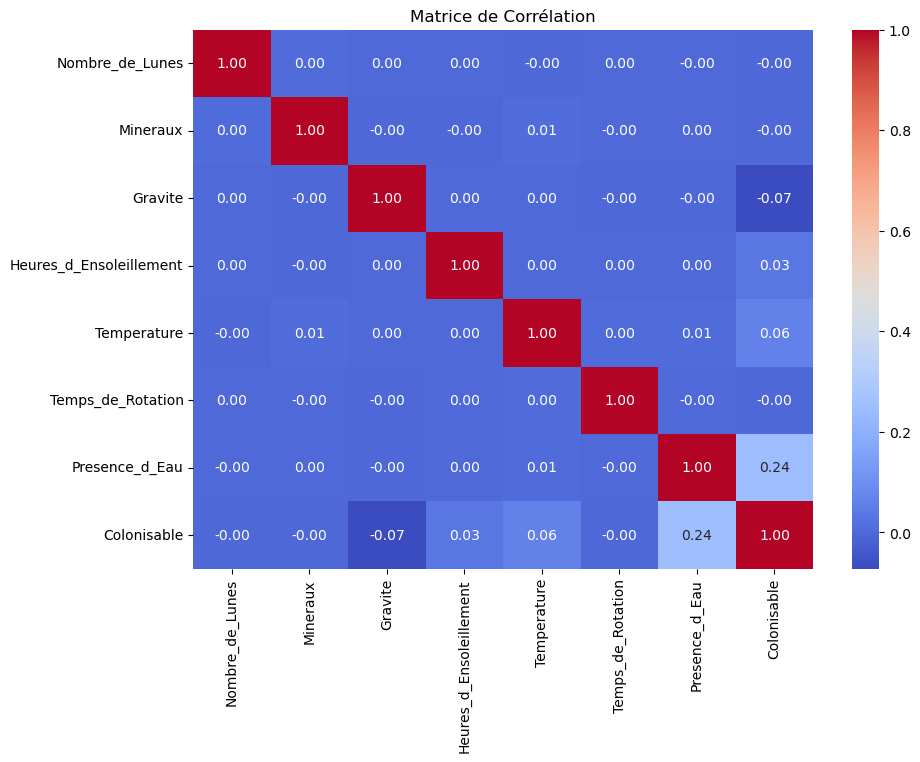

In [13]:
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de Corrélation")
plt.show()

### Diviser les données 

In [14]:
## Divise le dataframe
y  = df["Colonisable"]
X  = df.drop(["Colonisable", "Nom", "Nombre_de_Lunes", "Temps_de_Rotation", "Mineraux"] , axis = 1)


In [15]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Ajouter une dimension pour en faire un tableau 2D
# y_train = y_train.values.reshape(-1, 1)
# y_test = y_test.values.reshape(-1, 1)


### normaliser les donées d'entrée

In [16]:
# Normalisation des caractéristiques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_test_scaled.shape[1]



4

### Création du modèle 

In [17]:
model = Sequential([
    Dense(10, activation='relu', input_shape=(X_test_scaled.shape[1],)),
    Dense(26, activation='relu'),
    Dense(1, activation='sigmoid') 
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



### Entraînement du modèle et sauvegarde de l'historique

In [18]:
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=2, validation_data=(X_test_scaled, y_test))


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(32, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


2500/2500 - 8s - loss: 0.0000e+00 - accuracy: 0.9434 - val_loss: 0.0000e+00 - val_accuracy: 0.9447 - 8s/epoch - 3ms/step
Epoch 2/10
2500/2500 - 7s - loss: 0.0000e+00 - accuracy: 0.9439 - val_loss: 0.0000e+00 - val_accuracy: 0.9447 - 7s/epoch - 3ms/step
Epoch 3/10
2500/2500 - 6s - loss: 0.0000e+00 - accuracy: 0.9439 - val_loss: 0.0000e+00 - val_accuracy: 0.9447 - 6s/epoch - 3ms/step
Epoch 4/10
2500/2500 - 7s - loss: 0.0000e+00 - accuracy: 0.9439 - val_loss: 0.0000e+00 - val_accuracy: 0.9447 - 7s/epoch - 3ms/step
Epoch 5/10
2500/2500 - 8s - loss: 0.0000e+00 - accuracy: 0.9439 - val_loss: 0.0000e+00 - val_accuracy: 0.9447 - 8s/epoch - 3ms/step
Epoch 6/10
2500/2500 - 7s - loss: 0.0000e+00 - accuracy: 0.9439 - val_loss: 0.0000e+00 - val_accuracy: 0.9447 - 7s/epoch - 3ms/step
Epoch 7/10
2500/2500 - 8s - loss: 0.0000e+00 - accuracy: 0.9439 - val_loss: 0.0000e+00 - val_accuracy: 0.9447 - 8s/epoch - 3ms/step
Epoch 8/10
2500/2500 - 6s - loss: 0.0000e+00 - accuracy: 0.9439 - val_loss: 0.0000e+00 

### Tracer la courbe d'accuracy et de perte pendant l'entraînement

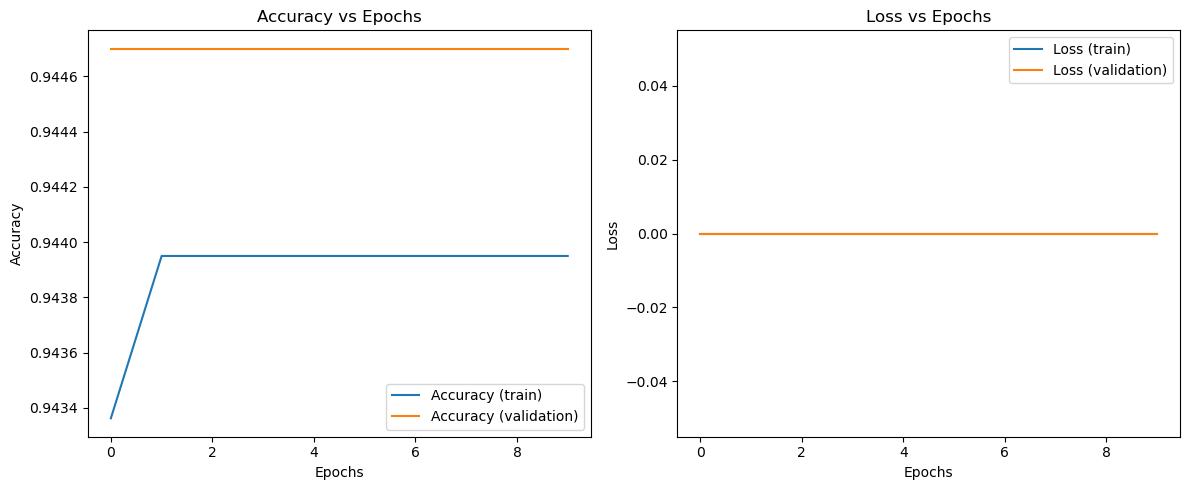

In [19]:

plt.figure(figsize=(12, 5))

# Tracer l'accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy (train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation)')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Tracer la perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Évaluation du modèle sur les données de test

In [20]:

loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

625/625 [==============================] - 2s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9447
Test Accuracy: 94.47%
